In [ ]:
# Check if running in Google Colab
try:
  from google.colab import drive
  running_in_colab = True
except ImportError:
  running_in_colab = False

In [ ]:
if running_in_colab:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
if running_in_colab:
    !pip install --upgrade OWSLib geopandas rasterio shapely
#!pip install pytorchtools

In [ ]:
# import packages
import os
import numpy as np
import cv2
from shapely.geometry import Polygon
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.geometry import box

In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


# Prepare training data

In [ ]:
import os

# Default local paths
data_folder = r"G:\Meine Ablage\data\382_5826_1\\"
model_path = r"G:\Meine Ablage\data\382_5826_1\models"
model_name = "model_4.pth"

# If running in Colab, update the paths
if running_in_colab:
  #drive.mount('/content/drive')
  data_folder = "/content/drive/MyDrive/data/382_5826_1/"
  model_path = "/content/drive/MyDrive/data/382_5826_1/models"

satellite_folder = os.path.join(data_folder, 'sliced_imgs_2020S')
vector_folder = os.path.join(data_folder, 'crowns')

# Ensure the paths exist
for folder in [model_path, satellite_folder, vector_folder]:
    if not os.path.exists(folder):
        raise FileNotFoundError(f"The folder {folder} does not exist")

# Get list of satellite images and vector layers
satellite_images = [os.path.join(satellite_folder, f) for f in os.listdir(satellite_folder) if f.endswith(".tif")]
vector_layers = {os.path.splitext(f)[0]: os.path.join(vector_folder, f) for f in os.listdir(vector_folder) if f.endswith(".geojson")}


In [ ]:
with rasterio.open(satellite_images[0]) as src:
    transform = src.transform

In [ ]:
def get_length_width(polygon):
    if polygon.is_empty or polygon.geom_type != 'Polygon':
        return None, None

    # Get the coordinates of the polygon and subtract the mean
    coords = np.array(polygon.exterior.coords)
    coords -= coords.mean(axis=0)

    # Perform PCA on the coordinates
    pca = PCA(2)
    coords_pca = pca.fit_transform(coords)

    # Create a new polygon using the transformed coordinates
    polygon_pca = Polygon(coords_pca)

    # The length and width of the polygon are the difference between the maximum
    # and minimum x and y values, respectively
    length = polygon_pca.bounds[2] - polygon_pca.bounds[0]
    width = polygon_pca.bounds[3] - polygon_pca.bounds[1]

    # return max and min as length and width
    return max(length, width), min(length, width)

def satisfies_ratio(polygon):
    length, width = get_length_width(polygon)
    if width == 0:  # To avoid division by zero
        return False
    ratio = length / width
    return ratio <= 2.4


In [ ]:
def vector_to_mask(polygon, image_shape, transform):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    if not polygon.empty:
        for idx, geom in enumerate(polygon):
            if geom is None:
                continue  # Skip this iteration if geom is None
            if geom.type == 'Polygon':
                if not satisfies_ratio(geom):
                  continue
                coords = np.array([geom.exterior.coords])
                coords_reshaped = coords.reshape(-1, 2)
                rows, cols = rasterio.transform.rowcol(transform, coords_reshaped[:, 0], coords_reshaped[:, 1])
                coords_t = np.column_stack((cols, rows)).astype(np.int32)
                cv2.fillPoly(mask, [coords_t], idx+1)
            elif geom.type == 'MultiPolygon':
                for poly_idx, poly in enumerate(geom.geoms):
                    if not satisfies_ratio(poly):
                      continue
                    coords = np.array([poly.exterior.coords])
                    coords_reshaped = coords.reshape(-1, 2)
                    rows, cols = rasterio.transform.rowcol(transform, coords_reshaped[:, 0], coords_reshaped[:, 1])
                    coords_t = np.column_stack((cols, rows)).astype(np.int32)
                    cv2.fillPoly(mask, [coords_t], idx+1+poly_idx)
            else:
                raise ValueError('Unknown geometry type: ' + geom.type)
    return mask

In [ ]:
import warnings
warnings.filterwarnings('ignore')

images = []
masks = []
matched = 0

for satellite_image in satellite_images:
    with rasterio.open(satellite_image) as src:
        img = src.read().transpose(1, 2, 0)[:, :, :3]
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        images.append(img)
        if (satellite_images.index(satellite_image)  == 2):
              print(src)
#        if len(images)==350:
#            print(base_name, vector_layers[base_name])
        base_name = os.path.splitext(os.path.basename(satellite_image))[0]
        if base_name in vector_layers:
            vector_layer = vector_layers[base_name]
            polygons = gpd.read_file(vector_layer)
            mask = vector_to_mask(polygons.geometry, img.shape, src.transform)
            matched = matched + 1
        else:
            mask = np.zeros(img.shape[:2], dtype=np.uint8)
        masks.append(mask)
print(matched)

<open DatasetReader name='/content/drive/MyDrive/data/382_5826_1/sliced_imgs_2020S/3dm_33_382_5827_1_be_0_2.tif' mode='r'>
292


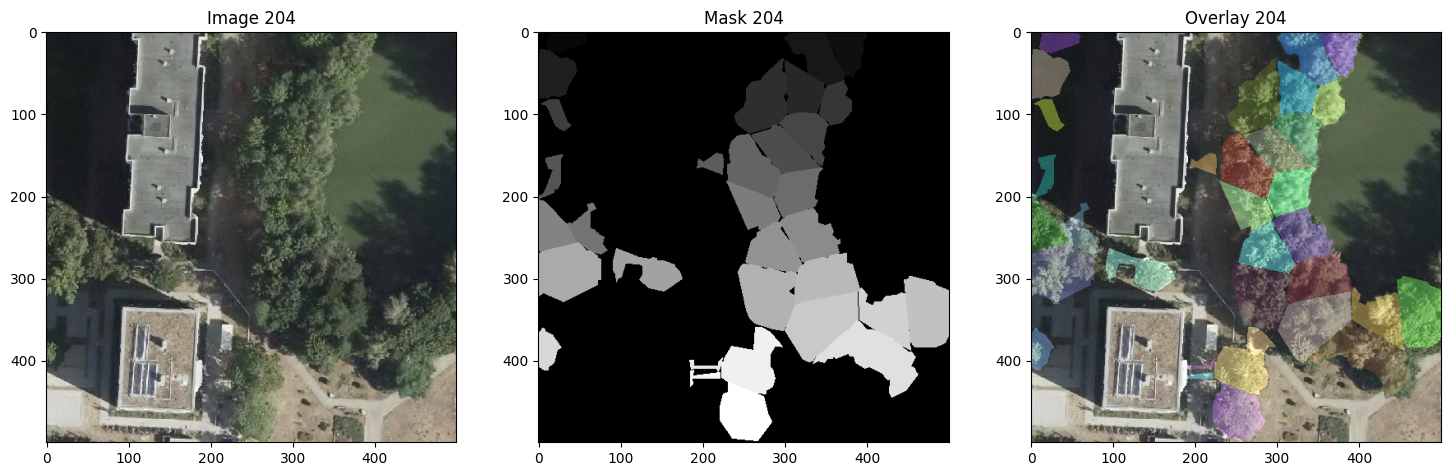

In [ ]:
def visualize_image_and_mask(image_idx, images, masks):
    def normalize_image(image):
        img_norm = image.copy()
        img_norm = cv2.normalize(img_norm, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        return img_norm

    image = images[image_idx]
    mask = masks[image_idx]

    # Normalize the image and mask
    image_normalized = normalize_image(image)
    mask_normalized = normalize_image(mask)

    # Create a random color map
    num_labels = np.max(mask_normalized) + 1
    random_color_map = np.random.randint(0, 256, (num_labels, 3), dtype=np.uint8)

    # Apply the random color map to the mask
    mask_colored = random_color_map[mask_normalized]

    # Set the alpha channel of the mask layer to 0 for the background pixels
    mask_alpha = np.where(mask_normalized == 0, 0, 1)

    # Create an overlay of the colored mask on the image
    overlay = image_normalized.copy()
    mask_colored_alpha = (mask_colored * mask_alpha[..., None]).astype(np.uint8)
    overlay = cv2.addWeighted(image_normalized, 1, mask_colored_alpha, 0.4, 0)

    # Visualize the original image, the mask, and the overlay
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    ax1.imshow(image_normalized)
    ax1.set_title(f'Image {image_idx}')
    ax2.imshow(mask_normalized, cmap='gray')
    ax2.set_title(f'Mask {image_idx}')
    ax3.imshow(overlay)
    ax3.set_title(f'Overlay {image_idx}')
    plt.show()

# Now you can visualize any image and its mask just by calling this function with the desired index: 2, 202, 204
visualize_image_and_mask(204, images, masks)

In [ ]:
# Splitting images and masks into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [ ]:
# Resize images if needed
def resize_images(images, size):
    resized_images = []
    for img in images:
        img_resized = cv2.resize(img, (size, size))
        resized_images.append(img_resized)
    return resized_images

size = 250  # Set a smaller size for the images
X_train_resized = resize_images(X_train, size)
y_train_resized = resize_images(y_train, size)
X_val_resized = resize_images(X_val, size)
y_val_resized = resize_images(y_val, size)

input_shape = (size, size, 3)

# Train pre-trained R-CNN model

In [ ]:
if running_in_colab:
    !python -m pip install pyyaml==5.1
    import sys, os, distutils.core
    # Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
    # See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
    !git clone 'https://github.com/facebookresearch/detectron2'
    dist = distutils.core.run_setup("./detectron2/setup.py")
    !python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
    sys.path.insert(0, os.path.abspath('./detectron2'))

fatal: destination path 'detectron2' already exists and is not an empty directory.


In [ ]:
!pip install --upgrade pillow

In [ ]:
import torch, detectron2
#!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch:  2.0 ; cuda:  cu118
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
if running_in_colab:
    from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
def create_coco_format_dataset(images, masks, output_json_path):
    data = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 0, "name": "tree_crown"}]
    }
    annotation_id = 1

    for i, (image, mask) in enumerate(zip(images, masks)):
        height, width, _ = image.shape

        data["images"].append({
            "id": i,
            "width": width,
            "height": height,
            "file_name": satellite_images[i]
        })
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            contour = np.squeeze(contour)
            if contour.size < 6:  # A contour should have at least 3 points (x, y) to form a valid polygon
                continue

            segmentation = contour.flatten().tolist()
            bbox = cv2.boundingRect(contour)
            area = cv2.contourArea(contour)

            # Subtract 1 from category_id to make it zero-indexed
            category_id = 0

            annotation = {
                "id": annotation_id,
                "image_id": i,
                "category_id": category_id,
                "segmentation": [segmentation],
                "bbox": bbox,
                "area": area,
                "iscrowd": 0
            }
            data["annotations"].append(annotation)
            annotation_id += 1

    with open(output_json_path, "w") as f:
        json.dump(data, f)


In [ ]:
os.makedirs(data_folder, exist_ok=True)

In [ ]:
create_coco_format_dataset(X_train, y_train, os.path.join(data_folder, "train.json"))
create_coco_format_dataset(X_val, y_val, os.path.join(data_folder, "val.json"))

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import load_coco_json

def get_train_data():
    return load_coco_json(os.path.join(data_folder, "train.json"), "/content/drive/MyDrive/data/382_5826_1/")

def get_val_data():
    return load_coco_json(os.path.join(data_folder, "val.json"), "/content/drive/MyDrive/data/382_5826_1/")

# Remove the datasets if they are already registered
if 'my_dataset_train' in DatasetCatalog.list():
    DatasetCatalog.remove('my_dataset_train')

if 'my_dataset_val' in DatasetCatalog.list():
    DatasetCatalog.remove('my_dataset_val')

# Register the datasets and metadata
DatasetCatalog.register("my_dataset_train", get_train_data)
MetadataCatalog.get("my_dataset_train").set(thing_classes=["tree_crown"])
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")

DatasetCatalog.register("my_dataset_val", get_val_data)
MetadataCatalog.get("my_dataset_val").set(thing_classes=["tree_crown"])
my_dataset_val_metadata = MetadataCatalog.get("my_dataset_val")


In [ ]:
from detectron2.config import CfgNode as CN
from detectron2.data import transforms as T

# Add custom data augmentation to the configuration
# Define the custom data augmentation
custom_augmentation = [
    T.RandomFlip(horizontal=True, vertical=False),
    T.RandomApply(T.RandomRotation(angle=[90, 90]), prob=0.5),
]

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
import os

from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog, DatasetCatalog

# Set the max_split_size_mb to potentially reduce fragmentation (this is optional and you might want to try without it first)
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb=10'

cfg = get_cfg()

# Backbone configuration
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")

# Dataset setup
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.VAL = ("my_dataset_val",)
cfg.DATASETS.TEST = ()  # No testing dataset
cfg.DATALOADER.NUM_WORKERS = 0
cfg.SOLVER.PATIENCE = 3

# Adjusting batch size and learning rate
cfg.SOLVER.IMS_PER_BATCH = 6  # Reduced from 12
cfg.SOLVER.BASE_LR = 0.0015  # Adjusted in proportion to batch size
cfg.SOLVER.MAX_ITER = 8000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Set the number of classes (1 class + 1 for the background)


print(cfg.DATASETS.TRAIN)
print(cfg.DATASETS.VAL)


('my_dataset_train',)
('my_dataset_val',)


In [ ]:
# Add the custom data augmentation to the config
cfg.AUGMENTATION = CN()
cfg.AUGMENTATION.TRAIN_PIPELINES = custom_augmentation

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name()}")
    torch.cuda.empty_cache()
    torch.cuda.memory_summary(device=None, abbreviated=False)
else:
    device = torch.device("cpu")
    cfg.MODEL.DEVICE = 'cpu'
    print("No GPU available, using CPU.")

GPU: Tesla T4


In [ ]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')  # <-- saves model to 'checkpoint.pt'
        self.val_loss_min = val_loss

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.utils.events import EventStorage, get_event_storage
from detectron2.engine.hooks import IterationTimer, LRScheduler

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

    def before_epoch(self, epoch):
        # Add your code here
        print(f"Before epoch {epoch}")
        hooks = self.build_hooks()
        with EventStorage() as storage:
            for hook in hooks:
                if hook is not None and not isinstance(hook, (IterationTimer, LRScheduler)):
                    hook.before_epoch()
            storage.put_scalar("epoch", epoch, smoothing_hint=False)
            # Perform any additional operations you need to do before the epoch starts

    def train(self):
        """
        This is a simple modification of the "train" method of DefaultTrainer
        to include early stopping.
        """
        super().train()
        early_stopping = EarlyStopping(patience=3, verbose=True)

        # Early stopping is based on validation loss
        for epoch in range(self.start_iter, self.max_iter):
            self.before_epoch(epoch)
            do_eval = self.run_step()  # Train for one epoch
            self.after_epoch()

            if do_eval:
                self._last_eval_results = self.test(self.cfg, self.model)
                val_loss = self._last_eval_results["bbox"]["AP"]

                early_stopping(val_loss, self.model)
                if early_stopping.early_stop:
                    print("Early stopping")
                    break

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.engine.hooks import HookBase
import torch

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1, self.EarlyStoppingHook(self.cfg.SOLVER.PATIENCE))
        return hooks

    class EarlyStoppingHook(HookBase):
        def __init__(self, patience):
            super().__init__()
            self.patience = patience
            self.counter = 0
            self.best_loss = float("inf")

        def after_epoch(self):
            val_loss = self.trainer.storage.history("validation_loss").latest()
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                self.counter = 0
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.trainer.should_stop = True

    def train(self):
        """
        This is a simple modification of the "train" method of DefaultTrainer
        to include early stopping.
        """
        super().train()

In [ ]:
# Load COCO annotation file
with open('/content/drive/MyDrive/data/382_5826_1/train.json', 'r') as f:
    data = json.load(f)

# Check each image
missing_files = []
for item in data['images']:
    if not os.path.exists(item['file_name']):
        missing_files.append(item['file_name'])

# Print out missing files
if missing_files:
    print(f"Missing {len(missing_files)} files:")
    for file_name in missing_files:
        print(file_name)
else:
    print("All files exist!")


All files exist!


In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
from detectron2.engine import DefaultTrainer

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
print(cfg.DATASETS.TRAIN)
print(cfg.DATASETS.VAL)
'''
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()
'''
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


('my_dataset_train',)
('my_dataset_val',)
[09/01 14:37:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=6

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[09/01 14:37:19 d2.engine.train_loop]: Starting training from iteration 0
[09/01 14:38:42 d2.utils.events]:  eta: 9:06:57  iter: 19  total_loss: 8.361  loss_cls: 0.7155  loss_box_reg: 0.1077  loss_mask: 0.6939  loss_rpn_cls: 5.372  loss_rpn_loc: 1.417    time: 4.0575  last_time: 3.7092  data_time: 0.2561  last_data_time: 0.3292   lr: 2.9971e-05  max_mem: 10777M
[09/01 14:40:05 d2.utils.events]:  eta: 9:01:40  iter: 39  total_loss: 3.406  loss_cls: 0.6043  loss_box_reg: 0.01749  loss_mask: 0.6872  loss_rpn_cls: 0.7191  loss_rpn_loc: 1.373    time: 4.0473  last_time: 4.1158  data_time: 0.2427  last_data_time: 0.2214   lr: 5.9941e-05  max_mem: 10777M
[09/01 14:41:27 d2.utils.events]:  eta: 9:02:21  iter: 59  total_loss: 3.151  loss_cls: 0.5323  loss_box_reg: 0.008239  loss_mask: 0.675  loss_rpn_cls: 0.573  loss_rpn_loc: 1.391    time: 4.0657  last_time: 4.3160  data_time: 0.2645  last_data_time: 0.3455   lr: 8.9911e-05  max_mem: 11073M
[09/01 14:42:47 d2.utils.events]:  eta: 8:59:54  iter

In [ ]:
# Get the model from the trainer
trained_model = trainer.model

# Save the trained model
torch.save(trained_model.state_dict(), f"{data_folder}/models/{model_name}")


## Evaluaton

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(model_path, model_name)

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_val",)
predictor = DefaultPredictor(cfg)

# Perform evaluation
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
inference_on_dataset(predictor.model, val_loader, evaluator)


In [ ]:
#from detectron2.engine import DefaultTrainer
#trainer = DefaultTrainer(cfg)
#coco_eval = trainer.test(cfg, trainer.model)

Intersection over Union (IoU) is a metric used to evaluate the performance of object detection models. It measures the overlap between the predicted bounding box and the ground truth bounding box. The IoU is calculated as the area of intersection divided by the area of union of the two bounding boxes.

The IoU threshold is a value that defines the minimum acceptable IoU for a predicted bounding box to be considered a true positive (a correct detection). For example, if the IoU threshold is set to 0.5, any predicted bounding box with an IoU of 0.5 or higher with respect to the ground truth bounding box will be considered a true positive.

When evaluating object detection models, it is common to calculate the Average Precision (AP) at various IoU thresholds to see how well the model performs across different levels of overlap between the predicted and ground truth bounding boxes. This provides a more comprehensive view of the model's performance, as the AP might be higher for lower IoU thresholds and lower for higher IoU thresholds.

For segmentation models, a desirable IoU value depends on the specific application and the level of accuracy required. In general, higher IoU values indicate better performance. Here are some general guidelines:

- IoU > 0.9: Excellent performance, with very high overlap between the predicted and ground truth segments.
- IoU between 0.75 and 0.9: Good performance, with a reasonable overlap between the predicted and ground truth segments.
- IoU between 0.5 and 0.75: Moderate performance, with some overlap between the predicted and ground truth segments, but room for improvement.
- IoU < 0.5: Poor performance, with low overlap between the predicted and ground truth segments.

For many applications, an IoU value above 0.75 is considered satisfactory. However, more stringent requirements might demand higher IoU values (e.g., medical image segmentation, where a high level of accuracy is crucial). It's important to consider the context and requirements of the specific application when determining an acceptable IoU value.

In [ ]:
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# Load the validation dataset
#val_loader = build_detection_test_loader(cfg, cfg.DATASETS.TEST[0])

# Create the COCOEvaluator
coco_evaluator = COCOEvaluator(cfg.DATASETS.TEST[0], cfg, True, output_dir=cfg.OUTPUT_DIR)

# Perform the evaluation
#results = inference_on_dataset(trainer.model, val_loader, coco_evaluator)
results = inference_on_dataset(predictor.model, val_loader, coco_evaluator)
print(metrics)

# Access the COCO evaluation results
coco_eval = coco_evaluator._results["segm"]

# IoU thresholds for 'AP50', and 'AP75' respectively
iou_thresholds = np.array([0.5, 0.75])

# Corresponding AP values
ap_values = np.array([coco_eval['AP50'], coco_eval['AP75']])

# Plot AP values for the specified IoU thresholds
plt.figure(figsize=(8, 6))
plt.plot(iou_thresholds, ap_values, marker='o')
plt.xlabel("IoU Threshold")
plt.ylabel("Average Precision (AP)")
plt.title("AP values for different IoU thresholds")
plt.grid()
plt.show()

# Test on new data

In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
import cv2

# Load the trained model
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.WEIGHTS = os.path.join(model_path, model_name)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.70 # Set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_val", )
predictor = DefaultPredictor(cfg)

# Load a new image for inference
new_image_path = "/content/drive/MyDrive/data/test_imgs/aoi00.tif"
#new_image = cv2.imread(new_image_path)
with rasterio.open(new_image_path) as src:
        new_image = src.read().transpose(1, 2, 0)[:, :, :3]
        new_image = cv2.normalize(new_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Make predictions
outputs = predictor(new_image)

# Visualize the predictions
v = Visualizer(new_image[:, :, ::-1],
               metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
               scale=0.8,
               instance_mode=ColorMode.IMAGE_BW)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2.imwrite("/content/drive/MyDrive/data/predicted_image.jpg", v.get_image()[:, :, ::-1])


In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import Instances
import cv2

def filter_by_size(predictions: Instances, max_area: int):
    if "pred_masks" in predictions._fields:
        areas = predictions.pred_masks.sum(dim=[1,2]).cpu().numpy()
    else:
        boxes = predictions.pred_boxes.tensor
        areas = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])

    keep = areas < max_area
    return predictions[torch.tensor(keep)]


# Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(model_path, model_name)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.50
cfg.DATASETS.TEST = ("my_dataset_val", )
predictor = DefaultPredictor(cfg)

# Load a new image for inference
new_image_path = "/content/drive/MyDrive/data/test_imgs/aoi00.tif"
with rasterio.open(new_image_path) as src:
    new_image = src.read().transpose(1, 2, 0)[:, :, :3]
    new_image = cv2.normalize(new_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Make predictions
outputs = predictor(new_image)

# Filter large predictions
MAX_AREA_THRESHOLD = 10000  # Adjust this value
filtered_instances = filter_by_size(outputs["instances"], MAX_AREA_THRESHOLD)
outputs["instances"] = filtered_instances

# Visualize the predictions
v = Visualizer(new_image[:, :, ::-1],
               metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
               scale=0.8,
               instance_mode=ColorMode.IMAGE_BW)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2.imwrite("/content/drive/MyDrive/data/predicted_image.jpg", v.get_image()[:, :, ::-1])

In [ ]:
# Plot the original satellite image
plt.imshow(new_image)
plt.title("Original Satellite Image")
plt.show()

# Scale the predicted mask to the original image size
predicted_mask_rescaled = cv2.resize(v.get_image()[:, :, ::-1], (new_image.shape[1], new_image.shape[0]))

# Plot the predicted mask
plt.imshow(predicted_mask_rescaled)
plt.title("Predicted Mask")
plt.show()


In [ ]:
# Get predicted masks
masks = outputs["instances"].pred_masks.cpu().numpy()

# Create an empty GeoDataFrame
gdf = gpd.GeoDataFrame(columns=["id", "geometry"])

# Iterate through the masks and add them as features to the GeoDataFrame
for i, mask in enumerate(masks):
    contours, _ = cv2.findContours((mask * 255).astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    for contour in contours:
        contour = contour.squeeze()
        if contour.size < 6:  # A contour should have at least 3 points (x, y) to form a valid polygon
            continue

        # Apply the inverse transformation to the contour points to obtain georeferenced coordinates
        contour_georef = rasterio.transform.xy(transform=transform, rows=contour[:, 1], cols=contour[:, 0])

        # Create a polygon from the contour points
        polygon = Polygon(zip(contour_georef[0], contour_georef[1]))

        # Add the polygon as a feature to the GeoDataFrame
        gdf = gdf.append({"id": i, "geometry": polygon}, ignore_index=True)

# Set the original CRS to EPSG:25833
gdf.crs = "EPSG:25833"

# Save the GeoDataFrame as a GeoJSON file
gdf.to_file("/content/drive/MyDrive/data/predicted_tree_crowns_EPSG25833.geojson", driver="GeoJSON")

In [ ]:
from rasterio.transform import Affine
# Extract polygon coordinates from the prediction
instances = outputs['instances'].to('cpu')
masks = instances.pred_masks.numpy()

polygons = []
for mask in masks:
    # Convert the mask to polygon using rasterio
    shapes = rasterio.features.shapes(mask.astype(np.uint8), mask=mask)
    for shape, value in shapes:
        if value == 1:
            # Create a polygon from the shape's coordinates
            polygon = Polygon(shape['coordinates'][0])
            polygons.append(polygon)

# Convert pixel coordinates to geographic coordinates using the provided affine transformation
transform = Affine(0.20, 0.00, 382000.00, 0.00, -0.20, 5827000.00)

polygons_geo = []
for polygon in polygons:
    polygon_geo_coords = [transform * coord for coord in polygon.exterior.coords]
    polygons_geo.append(Polygon(polygon_geo_coords))

# Create a GeoDataFrame with the polygon geometries
gdf = gpd.GeoDataFrame(geometry=polygons_geo, crs='EPSG:25833')

# Save the GeoDataFrame as a vector file (e.g., GeoJSON)
gdf.to_file("/content/drive/MyDrive/data/predicted_tree_crowns_EPSG25833_al2.geojson", driver="GeoJSON")


In [ ]:
gdf_wgs = gdf.to_crs(4326)
gdf_wgs.to_json()